<div>
<img img class="logo" src="https://medialib.cmcdn.dk/medialibrary/51432DDB-BBE3-4327-85F4-BE3493077470/1D874B35-F493-EC11-84B2-00155D0B0901.png" style="width: 100px;" align="right">
</div>

# <center> Assignment 2 - BuyWise Analytics

### <center> KAN-CDSCV1008U  Applied Machine Learning and Data Engineering in Business Context

## Data Preprocessing

In [118]:
# Importing modules 
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os

from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, accuracy_score

In [119]:
# Importing datasets 
path_frederik = "C:/Users/fredr/OneDrive/Documents/Master/Semester_3/Applied ML/AppliedML_Assign.01/Assignment2/Data/Features data set.csv"
path_mathijs = "C:/Users/blk/OneDrive/Documenten/GitHub/ML-Final/AppliedML_Assign.01/Assignment2/Data"

os.chdir(path_mathijs)
print(os.getcwd())

features = pd.read_csv("Features data set.csv")
sales = pd.read_csv("sales data-set.csv")
stores = pd.read_csv("stores data-set.csv")

C:\Users\blk\OneDrive\Documenten\GitHub\ML-Final\AppliedML_Assign.01\Assignment2\Data


In [120]:
# Convert the date column to datetime format 
features["Date"] = pd.to_datetime(features["Date"], format="%d/%m/%Y")
sales["Date"] = pd.to_datetime(sales["Date"], format="%d/%m/%Y")

`Data Prep`

In [121]:
# Forwoard fill impution for 'CPI' and 'Unemployment'
features['CPI'].fillna(method='ffill', inplace=True)
features['Unemployment'].fillna(method='ffill', inplace=True)

In [122]:
# Add weeks, year and quarter columns
features['week'] = features.Date.dt.isocalendar().week
features['year'] = features.Date.dt.year
features['quarter'] = features.Date.dt.quarter
print(features.head())

   Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3   
0      1 2010-02-05        42.31       2.572        NaN        NaN        NaN  \
1      1 2010-02-12        38.51       2.548        NaN        NaN        NaN   
2      1 2010-02-19        39.93       2.514        NaN        NaN        NaN   
3      1 2010-02-26        46.63       2.561        NaN        NaN        NaN   
4      1 2010-03-05        46.50       2.625        NaN        NaN        NaN   

   MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  week  year   
0        NaN        NaN  211.096358         8.106      False     5  2010  \
1        NaN        NaN  211.242170         8.106       True     6  2010   
2        NaN        NaN  211.289143         8.106      False     7  2010   
3        NaN        NaN  211.319643         8.106      False     8  2010   
4        NaN        NaN  211.350143         8.106      False     9  2010   

   quarter  
0        1  
1        1  
2        1  
3   

In [123]:
# Imputing Markdown columns
# Impute NaN values based on weekly average
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_columns:
    weekly_avg = features.groupby('week')[col].transform('mean')
    features[col].fillna(weekly_avg, inplace=True)

# can't impute all values for MarkDown2 , dropping Markdown2.

features.drop('MarkDown2', axis = 1, inplace=True)
print(features.head())
features.shape

   Store       Date  Temperature  Fuel_Price     MarkDown1   MarkDown3   
0      1 2010-02-05        42.31       2.572  24089.612333  198.031818  \
1      1 2010-02-12        38.51       2.548  29880.900556  197.092500   
2      1 2010-02-19        39.93       2.514  12536.748111   59.385610   
3      1 2010-02-26        46.63       2.561   8504.312444   25.995714   
4      1 2010-03-05        46.50       2.625  11293.039000   22.353662   

      MarkDown4    MarkDown5         CPI  Unemployment  IsHoliday  week  year   
0  24865.942619  4185.380333  211.096358         8.106      False     5  2010  \
1  20305.431829  5089.147556  211.242170         8.106       True     6  2010   
2   7038.310625  5646.276000  211.289143         8.106      False     7  2010   
3   2879.735679  4458.685000  211.319643         8.106      False     8  2010   
4   6312.144304  2911.005778  211.350143         8.106      False     9  2010   

   quarter  
0        1  
1        1  
2        1  
3        1  
4  

(8190, 14)

In [124]:
# Encoding 'IsHoliday' & 'Type'
label_encoder = LabelEncoder()
features['IsHoliday'] = label_encoder.fit_transform(features['IsHoliday'])
sales['IsHoliday'] = label_encoder.fit_transform(sales['IsHoliday'])
stores['Type'] = label_encoder.fit_transform(stores['Type'])

In [125]:
# Merging the data
tmp_df = pd.merge(sales, features, on=['Store', 'Date', 'IsHoliday'], how='left')
df = pd.merge(stores, tmp_df, on=['Store'], how='left')

In [126]:
df.columns

Index(['Store', 'Type', 'Size', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'week', 'year', 'quarter'],
      dtype='object')

In [127]:
# Grouping by Date, to get a weekly DataFrame, displaying mean sales over the entire company.
df_weekly = df.groupby("Date").agg({"Temperature": "mean",
                                                     "Weekly_Sales": "mean",
                                                     "Fuel_Price": "mean",
                                                     "CPI": "mean",
                                                     "Unemployment": "mean",
                                                      "IsHoliday": "min",
                                                      "MarkDown1": "mean",
                                                      "MarkDown3": "mean",
                                                      "MarkDown4": "mean",
                                                      "MarkDown5": "mean"})

In [128]:
print(df_weekly.head(),df_weekly.shape)

            Temperature  Weekly_Sales  Fuel_Price         CPI  Unemployment   
Date                                                                          
2010-02-05    33.277942  16836.121997    2.717869  167.398405      8.576731  \
2010-02-12    33.361810  16352.056032    2.696102  167.384138      8.567309   
2010-02-19    37.038310  16216.658979    2.673666  167.338966      8.576351   
2010-02-26    38.629563  14899.549688    2.685642  167.691019      8.561375   
2010-03-05    42.373998  15921.015727    2.731816  167.727351      8.572689   

            IsHoliday     MarkDown1   MarkDown3     MarkDown4    MarkDown5  
Date                                                                        
2010-02-05          0  24089.612333  198.031818  24865.942619  4185.380333  
2010-02-12          1  29880.900556  197.092500  20305.431829  5089.147556  
2010-02-19          0  12536.748111   59.385610   7038.310625  5646.276000  
2010-02-26          0   8504.312444   25.995714   2879.735679

In [129]:
df_weekly.reset_index(inplace=True)
print(df_weekly.head(5))

        Date  Temperature  Weekly_Sales  Fuel_Price         CPI  Unemployment   
0 2010-02-05    33.277942  16836.121997    2.717869  167.398405      8.576731  \
1 2010-02-12    33.361810  16352.056032    2.696102  167.384138      8.567309   
2 2010-02-19    37.038310  16216.658979    2.673666  167.338966      8.576351   
3 2010-02-26    38.629563  14899.549688    2.685642  167.691019      8.561375   
4 2010-03-05    42.373998  15921.015727    2.731816  167.727351      8.572689   

   IsHoliday     MarkDown1   MarkDown3     MarkDown4    MarkDown5  
0          0  24089.612333  198.031818  24865.942619  4185.380333  
1          1  29880.900556  197.092500  20305.431829  5089.147556  
2          0  12536.748111   59.385610   7038.310625  5646.276000  
3          0   8504.312444   25.995714   2879.735679  4458.685000  
4          0  11293.039000   22.353662   6312.144304  2911.005778  


In [130]:
# Add weeks, year and quarter columns
df_weekly['week'] = df_weekly.Date.dt.isocalendar().week
df_weekly['year'] = df_weekly.Date.dt.year
df_weekly['quarter'] = df_weekly.Date.dt.quarter
print(df_weekly.head())

        Date  Temperature  Weekly_Sales  Fuel_Price         CPI  Unemployment   
0 2010-02-05    33.277942  16836.121997    2.717869  167.398405      8.576731  \
1 2010-02-12    33.361810  16352.056032    2.696102  167.384138      8.567309   
2 2010-02-19    37.038310  16216.658979    2.673666  167.338966      8.576351   
3 2010-02-26    38.629563  14899.549688    2.685642  167.691019      8.561375   
4 2010-03-05    42.373998  15921.015727    2.731816  167.727351      8.572689   

   IsHoliday     MarkDown1   MarkDown3     MarkDown4    MarkDown5  week  year   
0          0  24089.612333  198.031818  24865.942619  4185.380333     5  2010  \
1          1  29880.900556  197.092500  20305.431829  5089.147556     6  2010   
2          0  12536.748111   59.385610   7038.310625  5646.276000     7  2010   
3          0   8504.312444   25.995714   2879.735679  4458.685000     8  2010   
4          0  11293.039000   22.353662   6312.144304  2911.005778     9  2010   

   quarter  
0        1  


In [131]:
# Create dummy variables for 'year' and 'week'
year_dummies = pd.get_dummies(df_weekly['year'], prefix='year').astype(int)
week_dummies = pd.get_dummies(df_weekly['week'], prefix='week').astype(int)
quarter_dummies = pd.get_dummies(df_weekly['quarter'], prefix='quarter').astype(int)

# Ensure all years and weeks columns exist using reindex
desired_year_columns = [f'year_{i}' for i in range(2010, 2014)]
desired_week_columns = [f'week_{i}' for i in range(1, 53)]
desired_quarter_columns = [f'quarter_{i}' for i in range(1,5)]

year_dummies = year_dummies.reindex(columns=desired_year_columns, fill_value=0)
week_dummies = week_dummies.reindex(columns=desired_week_columns, fill_value=0)
quarter_dummies = quarter_dummies.reindex(columns=desired_quarter_columns, fill_value=0)

# Concatenate the dummy variables back to the original dataframe
df_weekly = pd.concat([df_weekly, year_dummies, week_dummies, quarter_dummies], axis=1)

print(df_weekly.shape, '\n', df_weekly.head())


(143, 74) 
         Date  Temperature  Weekly_Sales  Fuel_Price         CPI  Unemployment   
0 2010-02-05    33.277942  16836.121997    2.717869  167.398405      8.576731  \
1 2010-02-12    33.361810  16352.056032    2.696102  167.384138      8.567309   
2 2010-02-19    37.038310  16216.658979    2.673666  167.338966      8.576351   
3 2010-02-26    38.629563  14899.549688    2.685642  167.691019      8.561375   
4 2010-03-05    42.373998  15921.015727    2.731816  167.727351      8.572689   

   IsHoliday     MarkDown1   MarkDown3     MarkDown4  ...  week_47  week_48   
0          0  24089.612333  198.031818  24865.942619  ...        0        0  \
1          1  29880.900556  197.092500  20305.431829  ...        0        0   
2          0  12536.748111   59.385610   7038.310625  ...        0        0   
3          0   8504.312444   25.995714   2879.735679  ...        0        0   
4          0  11293.039000   22.353662   6312.144304  ...        0        0   

   week_49  week_50  week_

In [132]:
df_weekly.drop(["week", "year", "quarter"],axis =1, inplace=True)
df_weekly.columns

Index(['Date', 'Temperature', 'Weekly_Sales', 'Fuel_Price', 'CPI',
       'Unemployment', 'IsHoliday', 'MarkDown1', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'year_2010', 'year_2011', 'year_2012', 'year_2013',
       'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7',
       'week_8', 'week_9', 'week_10', 'week_11', 'week_12', 'week_13',
       'week_14', 'week_15', 'week_16', 'week_17', 'week_18', 'week_19',
       'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25',
       'week_26', 'week_27', 'week_28', 'week_29', 'week_30', 'week_31',
       'week_32', 'week_33', 'week_34', 'week_35', 'week_36', 'week_37',
       'week_38', 'week_39', 'week_40', 'week_41', 'week_42', 'week_43',
       'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49',
       'week_50', 'week_51', 'week_52', 'quarter_1', 'quarter_2', 'quarter_3',
       'quarter_4'],
      dtype='object')

In [133]:
df_weekly.set_index('Date', inplace=True)

In [134]:
# Splitting the data into train- and test set
split_indx = int(0.8*len(df_weekly))

train = df_weekly[:split_indx]
test = df_weekly[split_indx:]

In [135]:
# Defining target variable and features 
X_train = train.drop('Weekly_Sales', axis=1)
y_train = train['Weekly_Sales']

X_test = test.drop('Weekly_Sales', axis=1)
y_test = test['Weekly_Sales']

In [136]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [137]:
# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [138]:
# Initialize Linear Regression 
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [139]:
print('Mean Absolute Error:', mean_absolute_error(y_test, lr_pred))
print('Mean Squared Error:', mean_squared_error(y_test, lr_pred))
print('R-squared:', r2_score(y_test, lr_pred))

Mean Absolute Error: 445.83707306472365
Mean Squared Error: 308220.2819648954
R-squared: 0.10183882902256192


C:\Users\blk\AppData\Local\Temp\ipykernel_17100\1522125439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['lr_pred'] = lr_pred


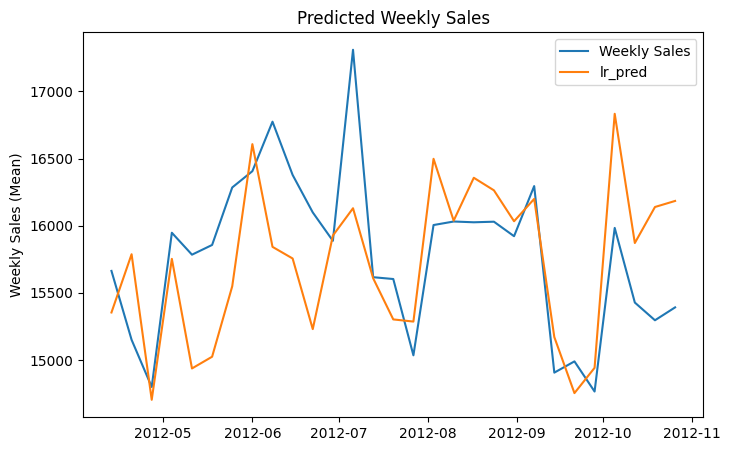

In [140]:
# Getting the predicted values from the regressor 
test['lr_pred'] = lr_pred

# Grouping the testset to prepare for visualizations
test.reset_index(inplace=True)
test_date = test.groupby('Date').agg({'Weekly_Sales': 'mean',
                                        'lr_pred': 'mean'}).reset_index()

# Plotting both 'Weekly_Sales' and 'Predictions'
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(test_date['Date'], test_date['Weekly_Sales'], label='Weekly Sales')
ax.plot(test_date['Date'], test_date['lr_pred'], label='lr_pred')

# Adding labels and title
ax.set_ylabel("Weekly Sales (Mean)")
ax.set_title('Predicted Weekly Sales')
ax.legend()

# Displaying the plot
plt.show()

In [145]:
# Initialize XGBoost Regressor
xgb = XGBRegressor(n_estimators=1000)
xgb.fit(X_train,y_train, verbose=False)
xgb_pred = xgb.predict(X_test)

In [146]:
print('Mean Absolute Error:', mean_absolute_error(y_test, xgb_pred))
print('Mean Squared Error:', mean_squared_error(y_test, xgb_pred))
print('R-squared:', r2_score(y_test, xgb_pred))

Mean Absolute Error: 988.8289526345535
Mean Squared Error: 1356305.5127949072
R-squared: -2.9523062525579444


In [114]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [115]:
print('Mean Absolute Error:', mean_absolute_error(y_test, rf_pred))
print('Mean Squared Error:', mean_squared_error(y_test, rf_pred))
print('R-squared:', r2_score(y_test, rf_pred))

Mean Absolute Error: 568.8062858750955
Mean Squared Error: 490308.7602786354
R-squared: -0.42877129131466973


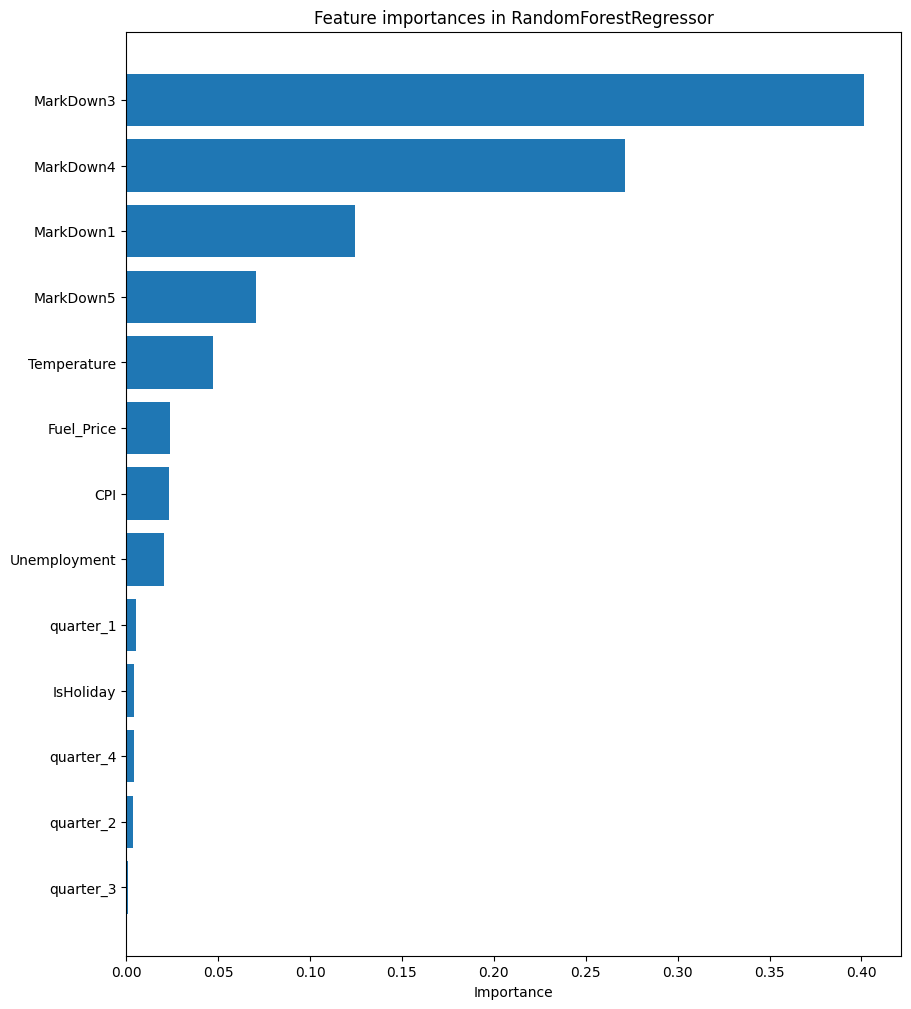

In [116]:
feature_importance = rf.feature_importances_
sorted_idx = feature_importance.argsort()
8
plt.figure(figsize=(10, 12))
plt.barh(range(X_train.shape[1]), feature_importance[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances in RandomForestRegressor')
plt.show()

In [117]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_



KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_rf.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))    
print('R-squared:', r2_score(y_test, y_pred))

Mean Absolute Error: 611.715203641342
Mean Squared Error: 588614.6902963762
R-squared: -0.7152370899178142


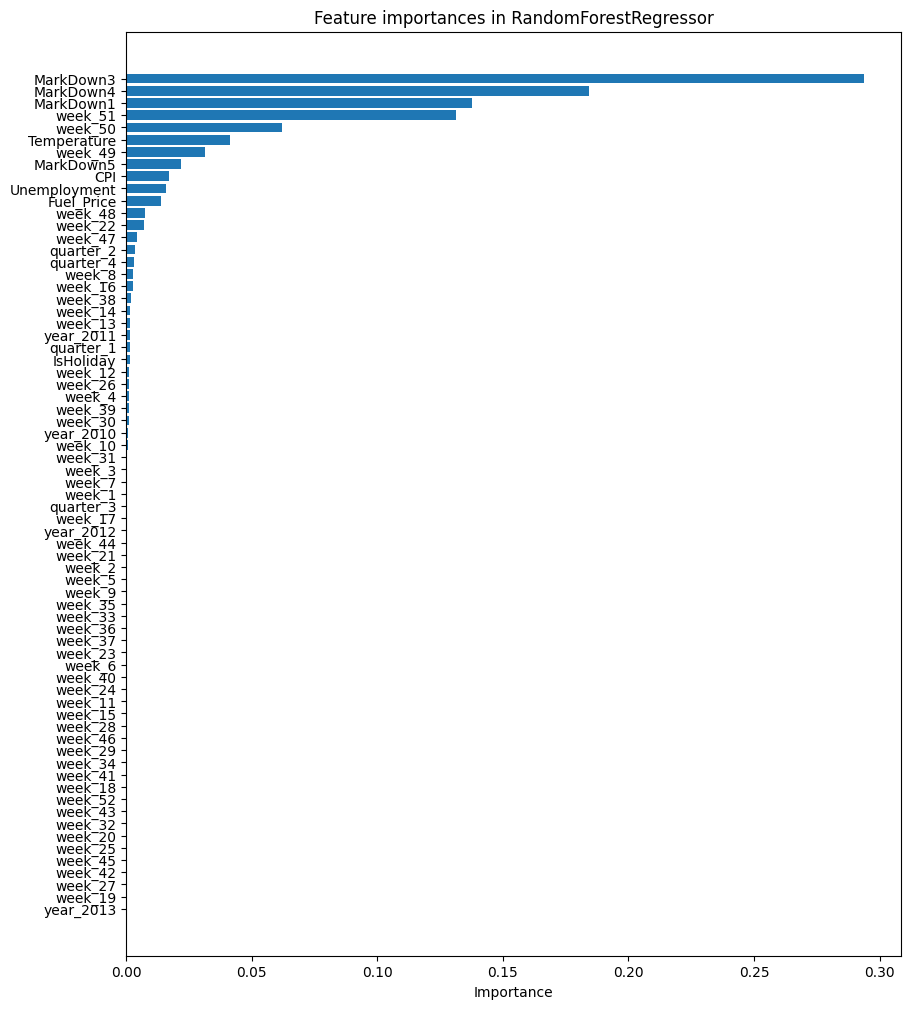

In [ ]:
feature_importance = best_rf.feature_importances_
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(10, 12))
plt.barh(range(X_train.shape[1]), feature_importance[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances in RandomForestRegressor')
plt.show()